In [17]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [18]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')  
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import io
dataset = pd.read_csv(io.BytesIO(uploaded['/content/spam.csv']), encoding = "ISO-8859-1")

In [ ]:
dataset

In [22]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''
training_portion = .8

In [23]:
articles = []
labels = []

with open("spam.csv", 'r', encoding = "ISO-8859-1") as dataset:
    reader = csv.reader(dataset, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

5572
5572


In [24]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

4457
4457
4457
1115
1115


In [25]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'': 1,
 'i': 2,
 'u': 3,
 'call': 4,
 'you': 5,
 '2': 6,
 'get': 7,
 "i'm": 8,
 'ur': 9,
 'now': 10}

In [26]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[8, 190, 37, 201, 30, 260, 293, 991, 222, 53, 153, 3815, 423, 46]


In [27]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

16
200
6
200
14
200


In [28]:
print(train_padded[10])

[   8  190   37  201   30  260  293  991  222   53  153 3815  423   46
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [29]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

1115
(1115, 200)


In [30]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[1]
[1]
[2]
(4457, 1)
[1]
[2]
[1]
(1115, 1)


In [31]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

i'm gonna home soon want talk stuff anymore tonight k i've cried enough today ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
I'm gonna home soon want talk stuff anymore tonight, k? I've cried enough today.


In [32]:
model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [33]:
print(set(labels))

{'ham', 'spam'}


In [34]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
140/140 - 22s - loss: 0.3193 - accuracy: 0.9210 - val_loss: 0.0552 - val_accuracy: 0.9839 - 22s/epoch - 154ms/step
Epoch 2/10
140/140 - 18s - loss: 0.0305 - accuracy: 0.9926 - val_loss: 0.0379 - val_accuracy: 0.9892 - 18s/epoch - 130ms/step
Epoch 3/10
140/140 - 18s - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0389 - val_accuracy: 0.9892 - 18s/epoch - 132ms/step
Epoch 4/10
140/140 - 19s - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0402 - val_accuracy: 0.9901 - 19s/epoch - 136ms/step
Epoch 5/10
140/140 - 18s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0474 - val_accuracy: 0.9910 - 18s/epoch - 130ms/step
Epoch 6/10
140/140 - 18s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0577 - val_accuracy: 0.9910 - 18s/epoch - 129ms/step
Epoch 7/10
140/140 - 19s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0753 - val_accuracy: 0.9865 - 19s/epoch - 132ms/step
Epoch 8/10
140/140 - 18s - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0536 - val_accuracy: 0.9839 - 18s/epoch - 129

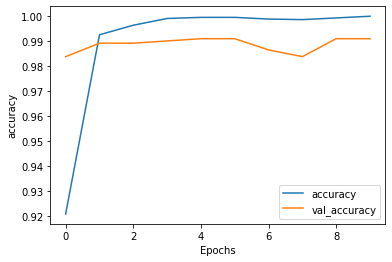

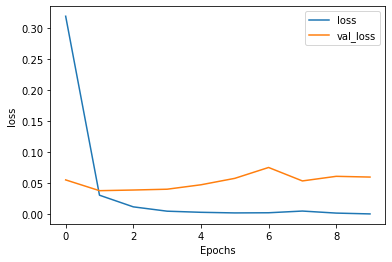

In [35]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")